In [14]:
import patchworklib as pw
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import t
from plotnine import ggplot, geom_histogram, aes, xlim, geom_point
from scipy.stats import t, norm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import random
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut

<Figure size 100x100 with 0 Axes>

# Question 1

In [2]:
# Read the data and seperate by ;
data = pd.read_csv('gdp_data.csv', sep=';')

data.drop(data.columns[0], axis=1, inplace=True)

display(data.head())

,income,capital,labor
0,114043,8310,182113
1,120410,8529,193749
2,129187,8738,205192
3,134705,8952,215130
4,139960,9171,225021


In [3]:
data['ln_capital'] = np.log(data['capital'])
data['ln_labor'] = np.log(data['labor'])

display(data.head())

,income,capital,labor,ln_capital,ln_labor
0,114043,8310,182113,9.025215,12.112383
1,120410,8529,193749,9.051227,12.174319
2,129187,8738,205192,9.075437,12.231701
3,134705,8952,215130,9.099632,12.278998
4,139960,9171,225021,9.123802,12.323949


In [4]:
# Add constant for the intercept term
Y = data['income']
X = data[['ln_capital', 'ln_labor']]
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(Y, X)

results = model.fit()

# Print model summary
print(results.summary())

# Print coefficients
print('Coefficients:', results.params)

                            OLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     971.4
Date:                Sun, 14 Apr 2024   Prob (F-statistic):           2.99e-18
Time:                        13:27:35   Log-Likelihood:                -206.83
No. Observations:                  20   AIC:                             419.7
Df Residuals:                      17   BIC:                             422.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.518e+06   1.76e+05    -14.271      0.0

Overall, based on the high R-squared value, low p-value of the F-statistic, and significant coefficient of ln_labor, we can conclude that the model provides an excellent fit to the data in explaining the variation in income. However, the non-significant coefficient for ln_capital suggests that this variable might not be a useful predictor of income in this model. Additionally, the low Durbin-Watson statistic indicates potential issues with autocorrelation in the residuals, which might need further investigation or model refinement.

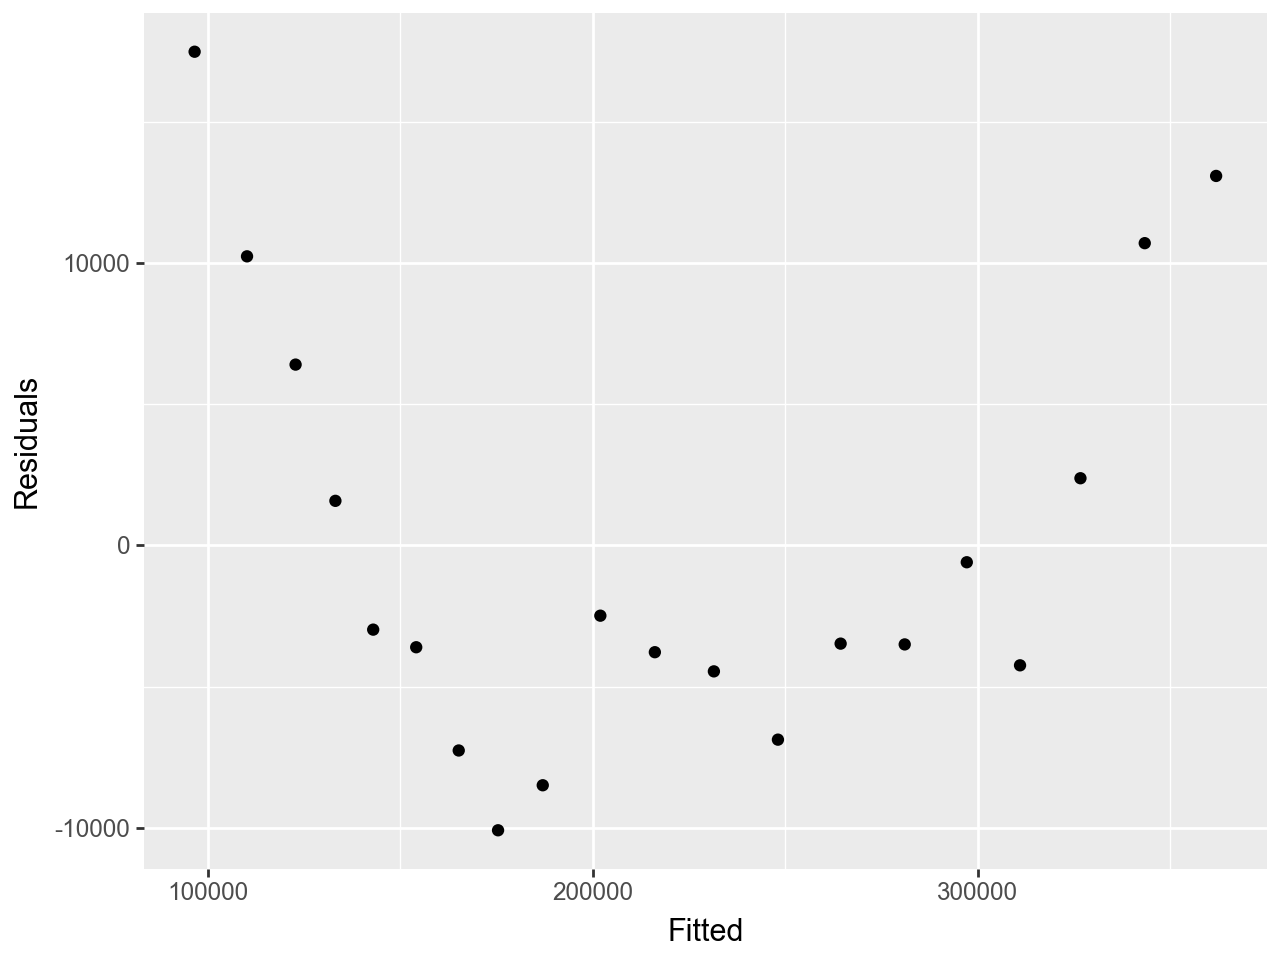

In [5]:
fitted_values = results.fittedvalues
residuals = results.resid
df = pd.DataFrame({'Fitted': fitted_values,
'Residuals': residuals})
plot = (
    ggplot(df,
    aes(x='Fitted', y='Residuals')) +
    geom_point()
)
plot.show()

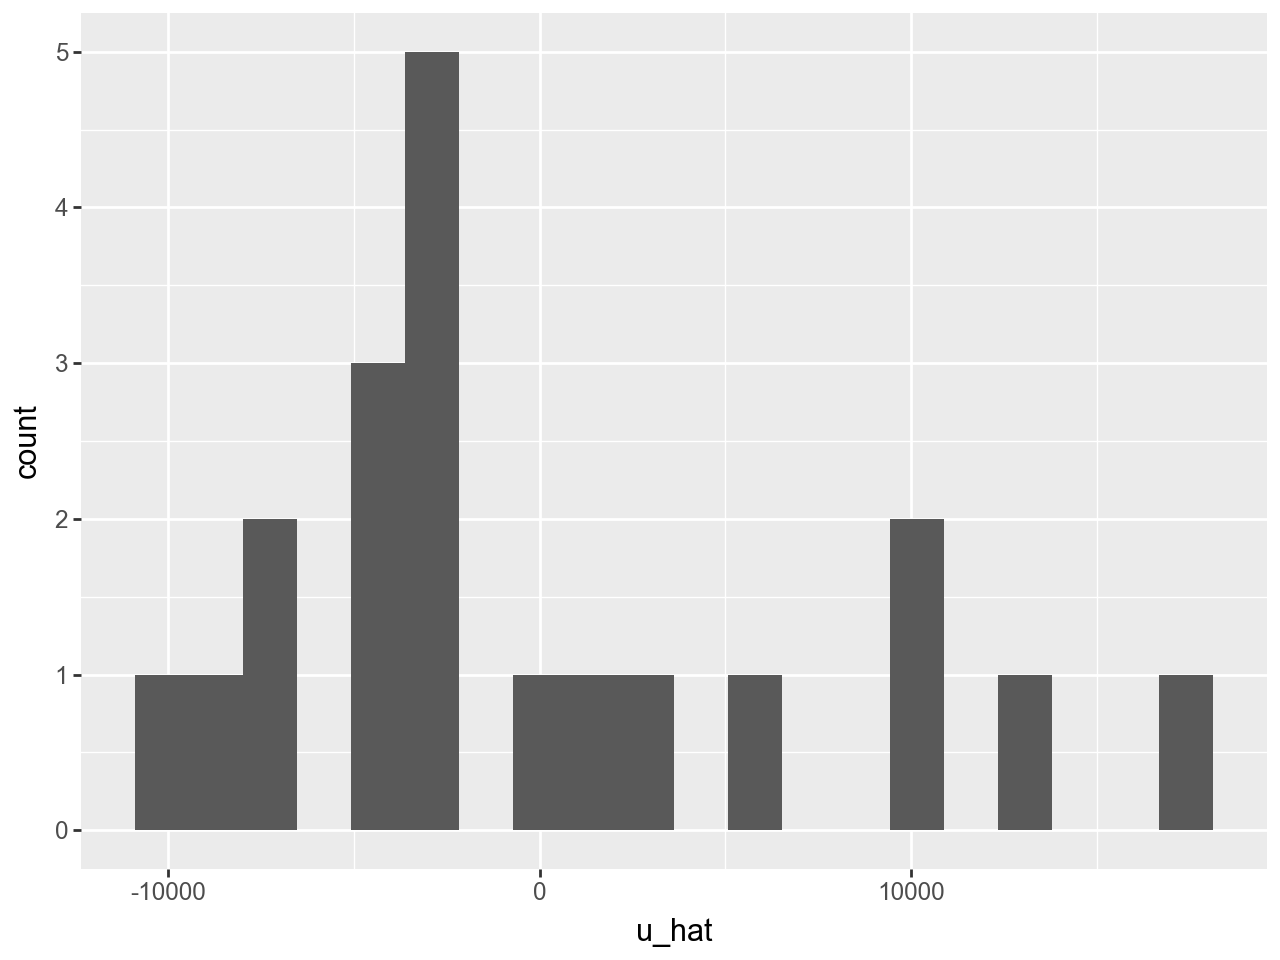

In [6]:
yhat = results.predict(X)
uhat = data['income'] - yhat
df = pd.DataFrame({'u_hat': uhat})
plot = (
ggplot(df,
aes(x='u_hat')) +
geom_histogram(bins = 20)
)

plot.show()

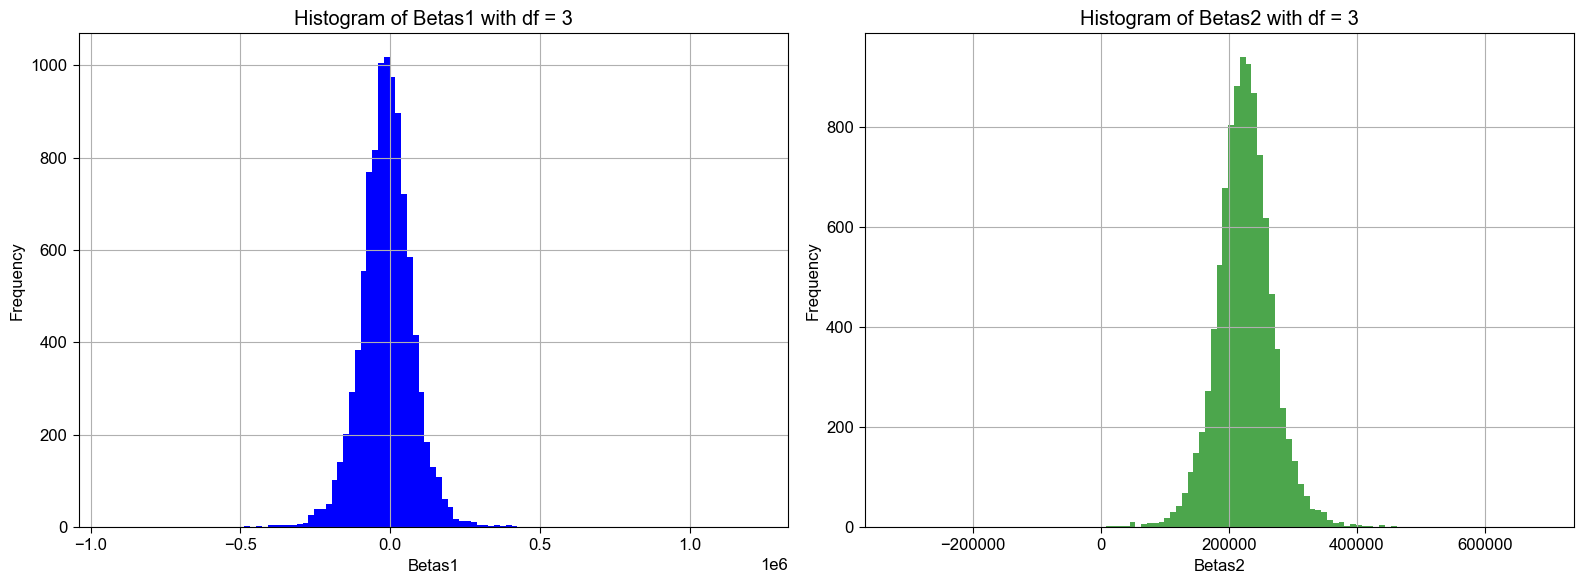

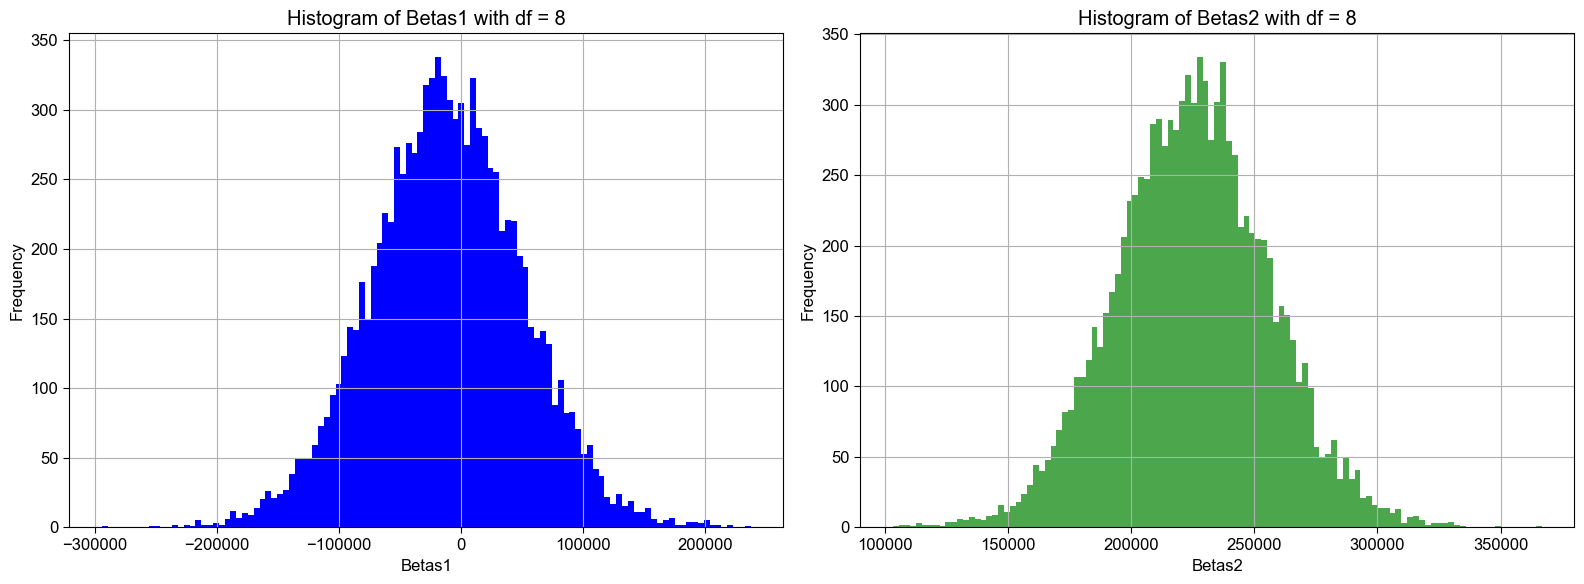

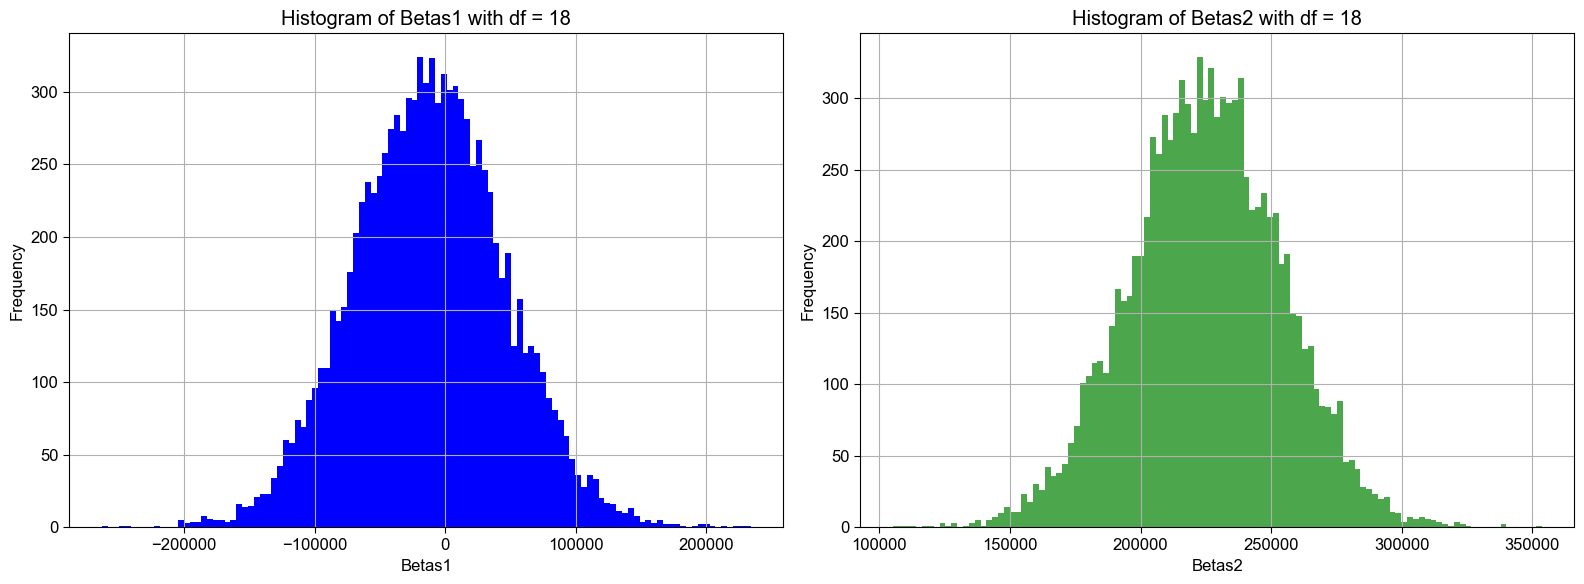

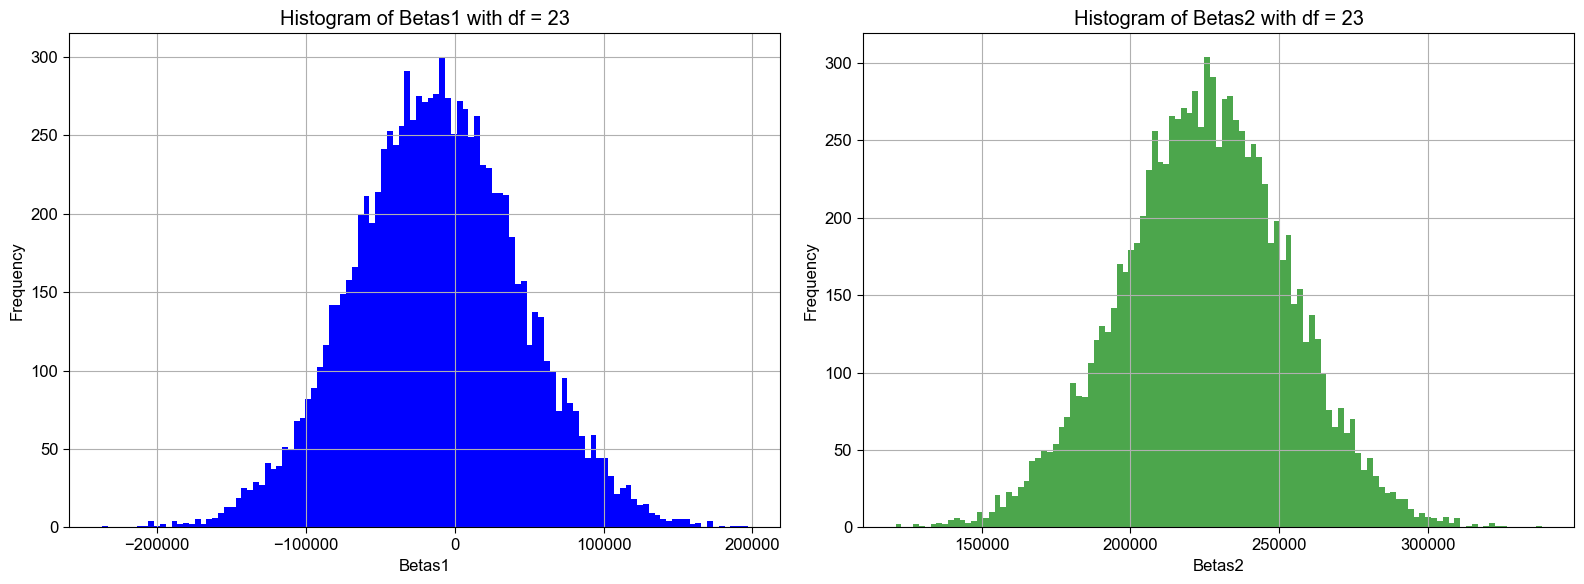

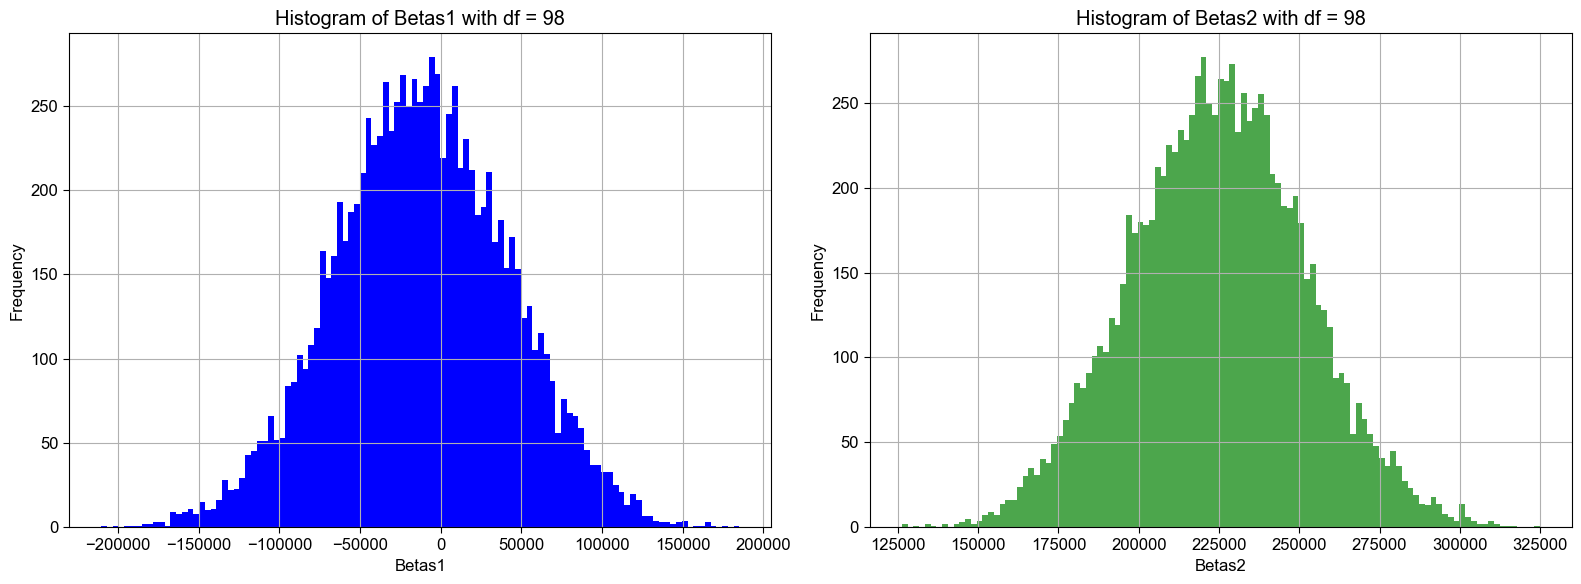

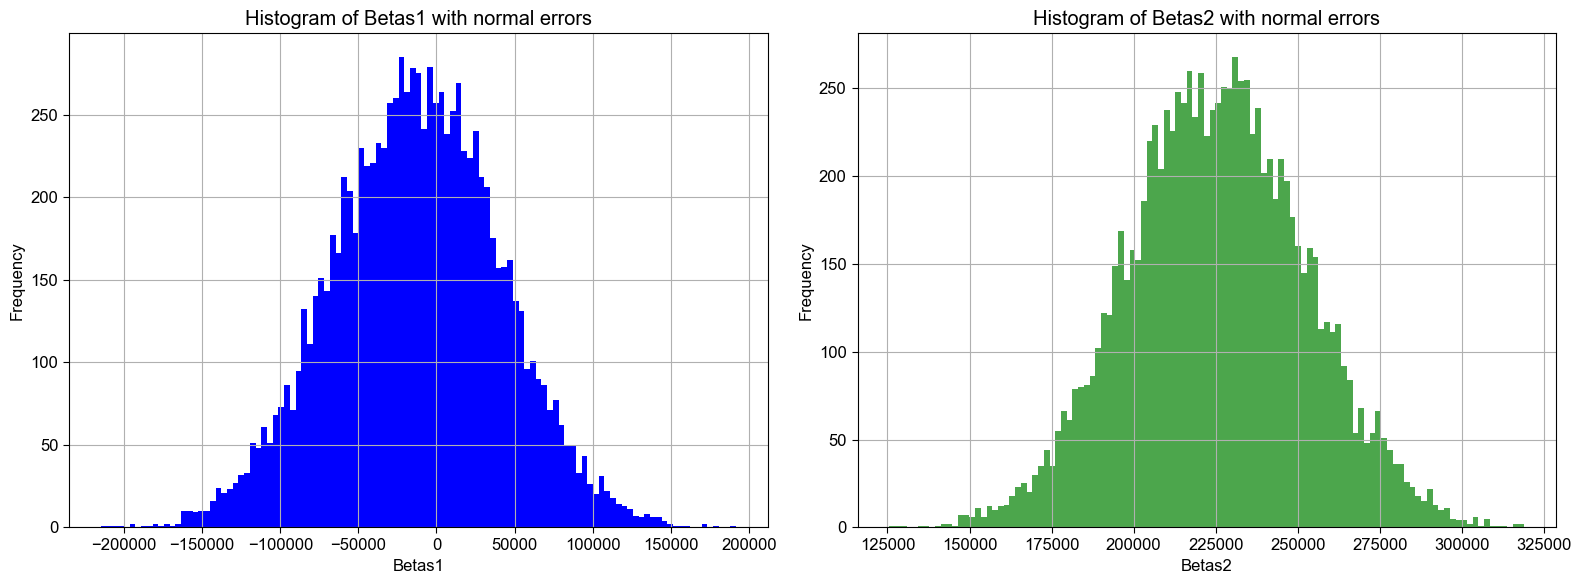

In [25]:
df_list = [5,10,20,25,100]

df_mean = []

for df in df_list + ["normal"]:
    MC = 10000
    BS = len(data)
    if df != "normal":
        df = df - 2

    y_vec = np.full((MC, BS),np.nan)
    betas0 = np.full(MC,np.nan)
    betas1 = np.full(MC,np.nan)
    betas2 = np.full(MC,np.nan)
    sdu = result = np.sqrt(np.sum((uhat ** 2) / (BS - 3)))

    for mc in range(MC):
        if df == "normal":
            u_normal = np.random.normal(size=BS) * sdu
            u_error = u_normal
        else:
            u_t = t.rvs(df, size=BS) * sdu
            u_error = u_t
        # MC
        y_tmp = results.params[0] +  results.params[1]*data['ln_capital']  + results.params[2]*data['ln_labor'] + u_error

        y_vec[mc, :] = y_tmp
        # Fit the model
        X_tmp = sm.add_constant(np.column_stack((data['ln_capital'], data['ln_labor'])))
        # Add a constant to the array
        fit_tmp = sm.OLS(y_tmp, X_tmp).fit()
        betas0[mc] = fit_tmp.params[0]
        betas1[mc] = fit_tmp.params[1]
        betas2[mc] = fit_tmp.params[2]

    betas_df = pd.DataFrame(
        {'betas0': betas0,
        'betas1':betas1,
        'betas2':betas2}
    )

    df_mean.append({
        'betas0': betas_df['betas0'].mean(),
        'betas1': betas_df['betas1'].mean(),
        'betas2': betas_df['betas2'].mean()
    })
    
    # Create a figure and axis with subplots
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))

    # Plot 1 - Histogram of Betas1
    if df == "normal":
        axs[0].hist(betas1, bins=int(500/(BS**0.5)), color='blue', alpha=1)
        axs[0].set_xlabel('Betas1')
        axs[0].set_ylabel('Frequency')
        axs[0].set_title('Histogram of Betas1 with normal errors')
        axs[0].grid(True)

        # Plot 2 - Histogram of Betas2
        axs[1].hist(betas2, bins=int(500/(BS**0.5)), color='green', alpha=0.7)
        axs[1].set_xlabel('Betas2')
        axs[1].set_ylabel('Frequency')
        axs[1].set_title('Histogram of Betas2 with normal errors')
        axs[1].grid(True)

    else:
        axs[0].hist(betas1, bins=int(500/(BS**0.5)), color='blue', alpha=1)
        axs[0].set_xlabel('Betas1')
        axs[0].set_ylabel('Frequency')
        axs[0].set_title(f'Histogram of Betas1 with df = {df}')
        axs[0].grid(True)

        # Plot 2 - Histogram of Betas2
        axs[1].hist(betas2, bins=int(500/(BS**0.5)), color='green', alpha=0.7)
        axs[1].set_xlabel('Betas2')
        axs[1].set_ylabel('Frequency')
        axs[1].set_title(f'Histogram of Betas2 with df = {df}')
        axs[1].grid(True)

    # Show the plots
    plt.tight_layout()
    plt.show()


In [34]:
df_mean = pd.DataFrame(df_mean)
results_params = pd.DataFrame(results.params)

df_mean["ratio_betas0"] = df_mean["betas0"] / float(results_params.iloc[0])
df_mean["ratio_betas1"] = df_mean["betas1"] / float(results_params.iloc[1])
df_mean["ratio_betas2"] = df_mean["betas2"] / float(results_params.iloc[2])

df_mean_copy = df_mean.copy()
df_mean_copy.index = [f"t({df})" for df in df_list] + ["normal"]
display(df_mean_copy)

,betas0,betas1,betas2,ratio_betas0,ratio_betas1,ratio_betas2
t(5),-2.520470e+06,-11609.173451,224708.008318,1.000929,0.960968,0.999276
t(10),-2.519533e+06,-11711.114356,224711.329254,1.000556,0.969407,0.999291
t(20),-2.520545e+06,-11960.095412,224971.875126,1.000958,0.990016,1.000449
t(25),-2.517731e+06,-12200.680294,224926.320853,0.999841,1.009931,1.000247
t(100),-2.518690e+06,-11549.526499,224524.853720,1.000222,0.956031,0.998462
normal,-2.516357e+06,-12807.098197,225265.015836,0.999295,1.060128,1.001753


The regression results present estimated coefficients for different parameters under various t-distribution values and a normal distribution. While the estimates for the constant term, ln_capital, and ln_labor coefficients generally approximate the real values of -2.518 million, -12,081, and 224,871 respectively, with minor variations across different t-distributions, the ratios of the estimated coefficients to the real values hover close to 1, indicating overall accuracy in estimation. This suggests that the model provides reliable parameter estimates, capturing the underlying relationships between the variables adequately across different distributional assumptions.




In [55]:
X

,ln_capital,ln_labor
0,9.025215,12.112383
1,9.051227,12.174319
2,9.075437,12.231701
3,9.099632,12.278998
4,9.123802,12.323949
5,9.166284,12.375925
6,9.161885,12.424794
7,9.175956,12.470976
8,9.243195,12.526219
9,9.303922,12.596011


In [66]:
chosen_estimators = df_mean.loc[4]
chosen_estimators = chosen_estimators.drop(['ratio_betas0', 'ratio_betas1', 'ratio_betas2'])


y_estimated = chosen_estimators[0] + chosen_estimators[1] * data['ln_capital'] + chosen_estimators[2] * data['ln_labor']

u_estimated = data["income"] - y_estimated

variance = np.matmul(u_estimated, u_estimated.T) / (100 - 3)

var_B = variance * np.linalg.inv(np.matmul(X.T, X))

standart_error = np.sqrt(np.diag(var_B))

# Question 2

In [79]:
# split the data into training and test sets (take first 10 to the training set and the rest to the test set)
train_set = data.iloc[:10]
test_set = data.iloc[10:]

# Add constant for the intercept term
Y = train_set['income']
X = train_set[['ln_capital', 'ln_labor']]
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(Y, X)

results = model.fit()
# Test the model on the test set
X_test = test_set[['ln_capital', 'ln_labor']]
X_test = sm.add_constant(X_test)

yhat = results.predict(X_test)

# Calculate MSE
M1_MSE = np.mean((test_set['income'] - yhat) ** 2)
print(f'Mean Squared Error: {M1_MSE}')

Mean Squared Error: 1812306775.8674698


In [80]:
# split the data into training and test sets (take first 10 to the training set and the rest to the test set)
train_set = data.iloc[:10]
test_set = data.iloc[10:]

# Add constant for the intercept term
Y = train_set['income']
X = train_set[['capital', 'labor']]
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(Y, X)

results = model.fit()
# Test the model on the test set
X_test = test_set[['capital', 'labor']]
X_test = sm.add_constant(X_test)

yhat = results.predict(X_test)

# Calculate MSE
M2_MSE = np.mean((test_set['income'] - yhat) ** 2)
print(f'Mean Squared Error: {M2_MSE}')

Mean Squared Error: 92448940.45616627


In [81]:
# split the data into training and test sets (take first 10 to the training set and the rest to the test set)
train_set = data.iloc[:10]
test_set = data.iloc[10:]

# Add constant for the intercept term
Y = train_set['income']
X = train_set[['capital', 'ln_labor']]
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(Y, X)

results = model.fit()
# Test the model on the test set
X_test = test_set[['capital', 'ln_labor']]
X_test = sm.add_constant(X_test)

yhat = results.predict(X_test)

# Calculate MSE
M3_MSE = np.mean((test_set['income'] - yhat) ** 2)
print(f'Mean Squared Error: {M3_MSE}')

Mean Squared Error: 972141750.53673


In [82]:
# split the data into training and test sets (take first 10 to the training set and the rest to the test set)
train_set = data.iloc[:10]
test_set = data.iloc[10:]

# Add constant for the intercept term
Y = train_set['income']
X = train_set[['ln_capital', 'labor']]
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(Y, X)

results = model.fit()
# Test the model on the test set
X_test = test_set[['ln_capital', 'labor']]
X_test = sm.add_constant(X_test)

yhat = results.predict(X_test)

# Calculate MSE
M4_MSE = np.mean((test_set['income'] - yhat) ** 2)
print(f'Mean Squared Error: {M4_MSE}')

Mean Squared Error: 64919212.82749287


In [85]:
mse_df = pd.DataFrame({
    'MSE': [M1_MSE, M2_MSE, M3_MSE, M4_MSE]
})
mse_df.index = ['M1', 'M2', 'M3', 'M4']

display(mse_df)

,MSE
M1,1.812307e+09
M2,9.244894e+07
M3,9.721418e+08
M4,6.491921e+07


## Summary and Comments on Linear Regression Models

### Model Performance Comparison

| Model | Independent Variables | Mean Squared Error (MSE) |
|-------|------------------------|---------------------------|
| M1    | ln_capital, ln_labor   | 1.812307e+09              |
| M2    | capital, labor         | 9.244894e+07              |
| M3    | capital, ln_labor      | 9.721418e+08              |
| M4    | ln_capital, labor      | 6.491921e+07              |

### Comments

- **Model Selection**: Based on MSE alone, Model 4 (M4) performs the best among the tested models with the lowest MSE. Model 2 (M2) also shows relatively low MSE compared to the others.
  
- **Variable Transformation**: It's apparent that transforming variables (taking the natural logarithm) in Model 1 and Model 3 did not improve model performance compared to using the original variables.
  
- **Variable Combination**: The combination of variables in Model 4 seems to capture the relationship between income and the predictors effectively, resulting in the lowest MSE.
  
- **Interpretation**: The results suggest that there might be a nonlinear relationship between income and capital (or labor), which is better captured by Model 4 compared to the other models.
  
- **Further Analysis**: It could be beneficial to explore other variable combinations, interactions, or polynomial terms to potentially improve model performance further. Additionally, considering diagnostic checks for model assumptions and multicollinearity could enhance the robustness of the analysis.


# Question 3

In [102]:
# Leave-One-Out Cross-Validation (LOOCV)

# Define the model 1
model = LinearRegression()

# Initialize an empty list to store the errors
errors = []

# Iterate over each row (observation) in the DataFrame
for i in range(len(data)):
    # Leave out the ith observation
    test_data = data.iloc[i]
    train_data = data.drop(index=i)
    
    # Add constant for the intercept term
    Y = train_set['income']
    X = train_set[['ln_capital', 'ln_labor']]
    X = sm.add_constant(X)

    # Fit the linear regression model
    model = sm.OLS(Y, X)

    results = model.fit()
    # Test the model on the test set
    X_test = test_data[['ln_capital', 'ln_labor']]
    X_test = sm.add_constant(X_test)

    yhat = results.params[0] + results.params[1] * test_data['ln_capital'] + results.params[2] * test_data['ln_labor']

    # Calculate MSE
    MSE1 = np.mean((test_data['income'] - yhat) ** 2)
    errors.append(MSE1)

# Calculate the average error
loocv_error_m1 = np.mean(errors)

print("LOOCV Error for Model 1:", loocv_error_m1)


LOOCV Error for Model 1: 909436950.8733288


In [103]:
# Define the model 2
model = LinearRegression()

# Initialize an empty list to store the errors
errors = []

# Iterate over each row (observation) in the DataFrame
for i in range(len(data)):
    # Leave out the ith observation
    test_data = data.iloc[i]
    train_data = data.drop(index=i)
    
    # Add constant for the intercept term
    Y = train_set['income']
    X = train_set[['capital', 'labor']]
    X = sm.add_constant(X)

    # Fit the linear regression model
    model = sm.OLS(Y, X)

    results = model.fit()
    # Test the model on the test set
    X_test = test_data[['capital', 'labor']]
    X_test = sm.add_constant(X_test)

    yhat = results.params[0] + results.params[1] * test_data['capital'] + results.params[2] * test_data['labor']

    # Calculate MSE
    MSE1 = np.mean((test_data['income'] - yhat) ** 2)
    errors.append(MSE1)

# Calculate the average error
loocv_error_m2 = np.mean(errors)

print("LOOCV Error for Model 2:", loocv_error_m2)


LOOCV Error for Model 2: 47458905.42439395


In [104]:
# Define the model 3
model = LinearRegression()

# Initialize an empty list to store the errors
errors = []

# Iterate over each row (observation) in the DataFrame
for i in range(len(data)):
    # Leave out the ith observation
    test_data = data.iloc[i]
    train_data = data.drop(index=i)
    
    # Add constant for the intercept term
    Y = train_set['income']
    X = train_set[['capital', 'ln_labor']]
    X = sm.add_constant(X)

    # Fit the linear regression model
    model = sm.OLS(Y, X)

    results = model.fit()
    # Test the model on the test set
    X_test = test_data[['capital', 'ln_labor']]
    X_test = sm.add_constant(X_test)

    yhat = results.params[0] + results.params[1] * test_data['capital'] + results.params[2] * test_data['ln_labor']

    # Calculate MSE
    MSE1 = np.mean((test_data['income'] - yhat) ** 2)
    errors.append(MSE1)

# Calculate the average error
loocv_error_m3 = np.mean(errors)

print("LOOCV Error for Model 3:", loocv_error_m3)


Mean Squared Error: 5811446.120075511
Mean Squared Error: 54193.918005681495
Mean Squared Error: 946505.7529739558
Mean Squared Error: 913684.0474872167
Mean Squared Error: 9523586.455270343
Mean Squared Error: 15424797.905059304
Mean Squared Error: 901444.0511887542
Mean Squared Error: 6374001.691737132
Mean Squared Error: 1652769.4417377913
Mean Squared Error: 4684816.381731983
Mean Squared Error: 21085908.151033588
Mean Squared Error: 98235957.47182582
Mean Squared Error: 349568484.86983174
Mean Squared Error: 524824121.831549
Mean Squared Error: 891023093.0735816
Mean Squared Error: 950373711.8686837
Mean Squared Error: 850032435.6644825
Mean Squared Error: 1499023684.6921744
Mean Squared Error: 226543733.05545524
Mean Squared Error: 4310706374.68869
LOOCV Error for Model 3: 488385237.5566288


In [105]:
# Define the model
model = LinearRegression()

# Initialize an empty list to store the errors
errors = []

# Iterate over each row (observation) in the DataFrame
for i in range(len(data)):
    # Leave out the ith observation
    test_data = data.iloc[i]
    train_data = data.drop(index=i)
    
    # Add constant for the intercept term
    Y = train_set['income']
    X = train_set[['ln_capital', 'labor']]
    X = sm.add_constant(X)

    # Fit the linear regression model
    model = sm.OLS(Y, X)

    results = model.fit()
    # Test the model on the test set
    X_test = test_data[['ln_capital', 'labor']]
    X_test = sm.add_constant(X_test)

    yhat = results.params[0] + results.params[1] * test_data['ln_capital'] + results.params[2] * test_data['labor']

    # Calculate MSE
    MSE1 = np.mean((test_data['income'] - yhat) ** 2)
    errors.append(MSE1)

# Calculate the average error
loocv_error_m4 = np.mean(errors)

print("LOOCV Error for Model 4:", loocv_error_m4)


Mean Squared Error: 6085589.783757292
Mean Squared Error: 220994.01383455118
Mean Squared Error: 1428618.8144098036
Mean Squared Error: 462321.1508254499
Mean Squared Error: 7808102.226133355
Mean Squared Error: 8109950.945492506
Mean Squared Error: 7774.788924397392
Mean Squared Error: 151335.4574685318
Mean Squared Error: 1845974.8111526198
Mean Squared Error: 10546991.165825257
Mean Squared Error: 1606349.6561410676
Mean Squared Error: 39155353.422303125
Mean Squared Error: 79849649.67926706
Mean Squared Error: 113725895.84376013
Mean Squared Error: 133584310.45894526
Mean Squared Error: 95032200.97475067
Mean Squared Error: 11013418.240570003
Mean Squared Error: 39113430.0972585
Mean Squared Error: 46668829.90016899
Mean Squared Error: 89442690.00176226
LOOCV Error for Model 4: 34292989.07163754


In [106]:
loocv_df = pd.DataFrame({
    'MSE': [loocv_error_m1, loocv_error_m2, loocv_error_m3, loocv_error_m4]
})
loocv_df.index = ['M1', 'M2', 'M3', 'M4']

display(loocv_df)

,MSE
M1,9.094370e+08
M2,4.745891e+07
M3,4.883852e+08
M4,3.429299e+07


# Leave-One-Out Cross-Validation (LOOCV)

## Model Evaluation

### Model 1 (ln_capital, ln_labor)
- **MSE:** 9.094370e+08

The average error (MSE) for Model 1 is quite high, indicating poor performance in predicting income. This could suggest that using the natural logarithm of capital and labor as predictors might not capture the relationship with income adequately.

### Model 2 (capital, labor)
- **MSE:** 4.745891e+07

The average error for Model 2 is considerably lower compared to Model 1. This suggests that using the original variables without taking their logarithms results in a better prediction of income. It's possible that the original scale of capital and labor better represents their relationship with income in this context.

### Model 3 (capital, ln_labor)
- **MSE:** 4.883852e+08

The average error for Model 3 is higher than that of Model 2 but lower than that of Model 1. This indicates that while using the original scale for capital is beneficial, taking the natural logarithm of labor might not improve the prediction of income as much as using the original scale for both variables.

### Model 4 (ln_capital, labor)
- **MSE:** 3.429299e+07

The average error for Model 4 is the lowest among all models. This suggests that using the natural logarithm of capital along with the original scale of labor results in the best prediction of income among the models tested. It appears that taking the logarithm of capital captures its relationship with income effectively, while using the original scale for labor is preferable.

## Summary
Based on LOOCV, Model 4 (ln_capital, labor) performs the best in predicting income, followed by Model 2 (capital, labor), Model 3 (capital, ln_labor), and lastly Model 1 (ln_capital, ln_labor). These findings provide insights into which combination of predictor variables yields the most accurate predictions of income in this context.


In [114]:
# Define the model 1
model = LinearRegression()

# Initialize an empty list to store the errors
errors_k2 = []
errors_k4 = []

# Extracting features and target variable
Y = data['income']
X = data[['ln_capital', 'ln_labor']]

# Define the number of folds
kf2 = KFold(n_splits=2)
kf4 = KFold(n_splits=4)

# Iterate over each fold
for train_index, test_index in kf2.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]

    # Fit the model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate MSE for k=2
    mse_k2 = np.mean((y_test - y_pred) ** 2)
    errors_k2.append(mse_k2)

# Calculate the average error for k=2
loocv_error_m1_k2 = np.mean(errors_k2)

# Repeat the process for k=4
for train_index, test_index in kf4.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]

    # Fit the model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate MSE for k=4
    mse_k4 = np.mean((y_test - y_pred) ** 2)
    errors_k4.append(mse_k4)

# Calculate the average error for k=4
loocv_error_m1_k4 = np.mean(errors_k4)


In [115]:
# Define the model 2
model = LinearRegression()

# Initialize an empty list to store the errors
errors_k2 = []
errors_k4 = []

# Extracting features and target variable
Y = data['income']
X = data[['capital', 'labor']]

# Define the number of folds
kf2 = KFold(n_splits=2)
kf4 = KFold(n_splits=4)

# Iterate over each fold
for train_index, test_index in kf2.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]

    # Fit the model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate MSE for k=2
    mse_k2 = np.mean((y_test - y_pred) ** 2)
    errors_k2.append(mse_k2)

# Calculate the average error for k=2
loocv_error_m2_k2 = np.mean(errors_k2)

# Repeat the process for k=4
for train_index, test_index in kf4.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]

    # Fit the model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate MSE for k=4
    mse_k4 = np.mean((y_test - y_pred) ** 2)
    errors_k4.append(mse_k4)

# Calculate the average error for k=4
loocv_error_m2_k4 = np.mean(errors_k4)


In [116]:
# Define the model 3
model = LinearRegression()

# Initialize an empty list to store the errors
errors_k2 = []
errors_k4 = []

# Extracting features and target variable
Y = data['income']
X = data[['capital', 'ln_labor']]

# Define the number of folds
kf2 = KFold(n_splits=2)
kf4 = KFold(n_splits=4)

# Iterate over each fold
for train_index, test_index in kf2.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]

    # Fit the model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate MSE for k=2
    mse_k2 = np.mean((y_test - y_pred) ** 2)
    errors_k2.append(mse_k2)

# Calculate the average error for k=2
loocv_error_m3_k2 = np.mean(errors_k2)

# Repeat the process for k=4
for train_index, test_index in kf4.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]

    # Fit the model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate MSE for k=4
    mse_k4 = np.mean((y_test - y_pred) ** 2)
    errors_k4.append(mse_k4)

# Calculate the average error for k=4
loocv_error_m3_k4 = np.mean(errors_k4)


In [117]:
# Define the model 4
model = LinearRegression()

# Initialize an empty list to store the errors
errors_k2 = []
errors_k4 = []

# Extracting features and target variable
Y = data['income']
X = data[['ln_capital', 'labor']]

# Define the number of folds
kf2 = KFold(n_splits=2)
kf4 = KFold(n_splits=4)

# Iterate over each fold
for train_index, test_index in kf2.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]

    # Fit the model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate MSE for k=2
    mse_k2 = np.mean((y_test - y_pred) ** 2)
    errors_k2.append(mse_k2)

# Calculate the average error for k=2
loocv_error_m4_k2 = np.mean(errors_k2)

# Repeat the process for k=4
for train_index, test_index in kf4.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]

    # Fit the model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate MSE for k=4
    mse_k4 = np.mean((y_test - y_pred) ** 2)
    errors_k4.append(mse_k4)

# Calculate the average error for k=4
loocv_error_m4_k4 = np.mean(errors_k4)


In [118]:
k_fold_df = pd.DataFrame({
    'k=2': [loocv_error_m1_k2, loocv_error_m2_k2, loocv_error_m3_k2, loocv_error_m4_k2],
    'k=4': [loocv_error_m1_k4, loocv_error_m2_k4, loocv_error_m3_k4, loocv_error_m4_k4]
})
k_fold_df.index = ['M1', 'M2', 'M3', 'M4']

display(k_fold_df)

,k=2,k=4
M1,1.146490e+09,2.411299e+08
M2,3.021337e+08,1.683934e+08
M3,6.968058e+08,2.126814e+08
M4,2.812487e+08,1.109897e+08


# Question 5

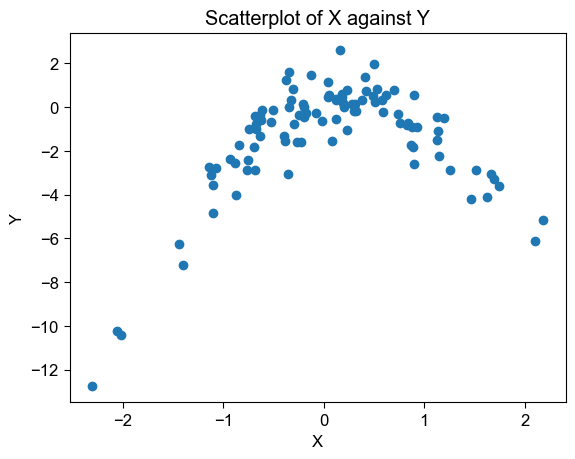

In [125]:
np.random.seed(1)
x = np.random.normal(size=100)
y = x - 2 * x**2 + np.random.normal(size=100)

# Create a scatterplot of X against Y.
plt.scatter(x, y)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Scatterplot of X against Y')
plt.show()

### Analysis of Scatter Plot

1. **Non-linear Relationship**: The relationship between X and Y appears to be non-linear, as indicated by the curvature in the scatter plot. This is expected because of the quadratic term in the generation of the Y variable (`-2 * x**2`).

2. **Centered around X-axis**: The majority of the data points seem to be concentrated around the X-axis, particularly for larger values of X. This is likely due to the negative quadratic term in the generation of Y, which tends to pull the values downward as X increases.

3. **Scattered Distribution**: While there's a general trend, the data points are quite scattered, indicating variability in Y for any given value of X. This variability could be due to the random noise added during the generation of both X and Y.

4. **Overall Trend**: Despite the scatter, there's still a discernible downward trend as X increases, reflecting the influence of the quadratic term in the generation of Y.

5. **Randomness**: The presence of random noise in both X and Y adds stochasticity to the relationship, making it difficult to predict Y precisely for a given X.

Overall, the scatter plot effectively visualizes the relationship between X and Y, highlighting the non-linear nature of their association and the presence of random variability.


In [136]:
# Generate data
np.random.seed(1)
x = np.random.normal(size=100)
y = x - 2 * x**2 + np.random.normal(size=100)

# Reshape x and y for sklearn
x = x.reshape(-1, 1)
y = y.reshape(-1, 1)

# Initialize LOOCV
loo = LeaveOneOut()

# Initialize lists to store MSE values
mse_values = []

# Define degrees for polynomial regression
degrees = [1, 2, 3, 4]

# Iterate over degrees
for degree in degrees:
    # Initialize list to store errors for each degree
    errors = []
    
    # Fit the model and compute LOOCV errors
    for train_index, test_index in loo.split(x):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Create polynomial features
        poly = PolynomialFeatures(degree=degree, include_bias=False)
        x_train_poly = poly.fit_transform(x_train)
        x_test_poly = poly.transform(x_test)
        
        # Fit linear regression model
        model = LinearRegression()
        model.fit(x_train_poly, y_train)
        
        # Predict the left-out data point
        y_pred = model.predict(x_test_poly)
        
        # Compute error
        error = mean_squared_error(y_test, y_pred)
        errors.append(error)
    
    # Calculate mean squared error (MSE) for the current degree
    mse = np.mean(errors)
    mse_values.append(mse)

# Print MSE values for each degree
for degree, mse in zip(degrees, mse_values):
    print(f"Degree {degree}: Mean Squared Error (MSE) of LOOCV = {mse}")

Degree 1: Mean Squared Error (MSE) of LOOCV = 6.260764331604616
Degree 2: Mean Squared Error (MSE) of LOOCV = 0.9142897072803663
Degree 3: Mean Squared Error (MSE) of LOOCV = 0.9268768781648808
Degree 4: Mean Squared Error (MSE) of LOOCV = 0.8669116865881078


In [137]:
# Generate data
np.random.seed(1312312)
x = np.random.normal(size=100)
y = x - 2 * x**2 + np.random.normal(size=100)

# Reshape x and y for sklearn
x = x.reshape(-1, 1)
y = y.reshape(-1, 1)

# Initialize LOOCV
loo = LeaveOneOut()

# Initialize lists to store MSE values
mse_values = []

# Define degrees for polynomial regression
degrees = [1, 2, 3, 4]

# Iterate over degrees
for degree in degrees:
    # Initialize list to store errors for each degree
    errors = []
    
    # Fit the model and compute LOOCV errors
    for train_index, test_index in loo.split(x):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Create polynomial features
        poly = PolynomialFeatures(degree=degree, include_bias=False)
        x_train_poly = poly.fit_transform(x_train)
        x_test_poly = poly.transform(x_test)
        
        # Fit linear regression model
        model = LinearRegression()
        model.fit(x_train_poly, y_train)
        
        # Predict the left-out data point
        y_pred = model.predict(x_test_poly)
        
        # Compute error
        error = mean_squared_error(y_test, y_pred)
        errors.append(error)
    
    # Calculate mean squared error (MSE) for the current degree
    mse = np.mean(errors)
    mse_values.append(mse)

# Print MSE values for each degree
for degree, mse in zip(degrees, mse_values):
    print(f"Degree {degree}: Mean Squared Error (MSE) of LOOCV = {mse}")

Degree 1: Mean Squared Error (MSE) of LOOCV = 8.31720136699923
Degree 2: Mean Squared Error (MSE) of LOOCV = 1.1203553673267843
Degree 3: Mean Squared Error (MSE) of LOOCV = 1.1257131831742606
Degree 4: Mean Squared Error (MSE) of LOOCV = 1.1559225588601576


The results in (d) are different from those in (c), which is expected. This discrepancy arises due to the random nature of data generation and the LOOCV process.

In both (c) and (d), new random data sets `x` and `y` are generated using different random seeds (`1` in (c) and `1312312` in (d)). These random seeds lead to different random numbers being generated, resulting in different datasets.

Since LOOCV involves leaving out one data point at a time for validation, the specific data points left out for validation will differ between the two runs. Consequently, the fitted models and resulting errors will vary.

The differences between the two sets of results illustrate the variability introduced by random data generation and the LOOCV procedure.


The 4th order one has the most thoughtful MSE.

I wouldn't expect this to happen because the data we generate is generated using a 2nd order polynomial. So I would expect more MSE for the ones lower and higher than 2nd order. However, since randomization is involved, it is quite normal that the MSE is not as expected. I expected the 4th order polynomial to give a higher MSE due to overfitting, but I did not get the result I expected.

In [15]:
np.random.seed(1)
X = np.random.normal(size=100)
Y = X - 2 * X**2 + np.random.normal(size=100)

X_with_constant = sm.add_constant(X)

# Fit the model
model = sm.OLS(Y, X_with_constant)
results = model.fit()

# Print the summary statistics
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     9.997
Date:                Mon, 15 Apr 2024   Prob (F-statistic):            0.00209
Time:                        22:56:25   Log-Likelihood:                -228.87
No. Observations:                 100   AIC:                             461.7
Df Residuals:                      98   BIC:                             466.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.4131      0.242     -5.849      0.0

In [10]:
np.random.seed(1)
X = np.random.normal(size=100)
Y = X - 2 * X**2 + np.random.normal(size=100)

X_design = sm.add_constant(np.column_stack((X, X**2)))

# Fit the model
model = sm.OLS(Y, X_design)
results = model.fit()

# Print the summary statistics
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     304.9
Date:                Mon, 15 Apr 2024   Prob (F-statistic):           1.47e-42
Time:                        22:55:25   Log-Likelihood:                -134.42
No. Observations:                 100   AIC:                             274.8
Df Residuals:                      97   BIC:                             282.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1350      0.115      1.169      0.2

In [11]:
np.random.seed(1)
X = np.random.normal(size=100)
Y = X - 2 * X**2 + np.random.normal(size=100)

X_design = sm.add_constant(np.column_stack((X, X**2, X**3)))

# Fit the model
model = sm.OLS(Y, X_design)
results = model.fit()

# Print the summary statistics
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     204.8
Date:                Mon, 15 Apr 2024   Prob (F-statistic):           1.40e-41
Time:                        22:55:25   Log-Likelihood:                -133.66
No. Observations:                 100   AIC:                             275.3
Df Residuals:                      96   BIC:                             285.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1280      0.115      1.111      0.2

In [12]:
np.random.seed(1)
X = np.random.normal(size=100)
Y = X - 2 * X**2 + np.random.normal(size=100)

X_design = sm.add_constant(np.column_stack((X, X**2, X**3, X**4)))

# Fit the model
model = sm.OLS(Y, X_design)
results = model.fit()

# Print the summary statistics
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     163.0
Date:                Mon, 15 Apr 2024   Prob (F-statistic):           1.24e-41
Time:                        22:55:25   Log-Likelihood:                -130.63
No. Observations:                 100   AIC:                             271.3
Df Residuals:                      95   BIC:                             284.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3140      0.136      2.311      0.0

The coefficient with 2nd order has the highest t-value. This is not a coincidence because our data is directly generated by a quadratic polynomial, so it is normal that the most statistically significant coefficient is Beta_2.

We can't say it's exactly the same. Because, when we do LOOCV, if we use seed(1), the minimum MSE corresponds to a 4th order polynomial. However, our most statistically important variable is x^2. 

# Question 6

Average Correlation Estimate (Sample Size 5): 0.7092674532693167


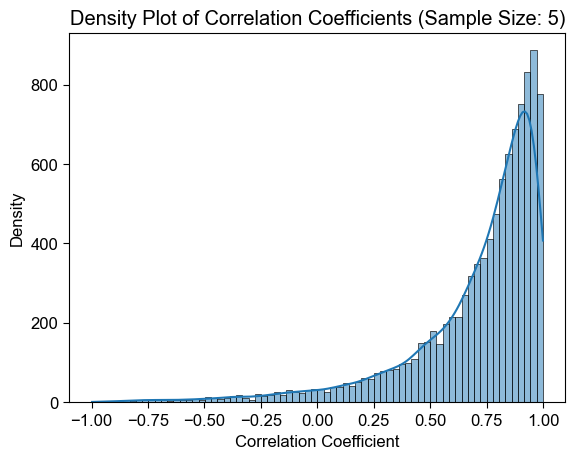

Average Correlation Estimate (Sample Size 10): 0.7368455497078386


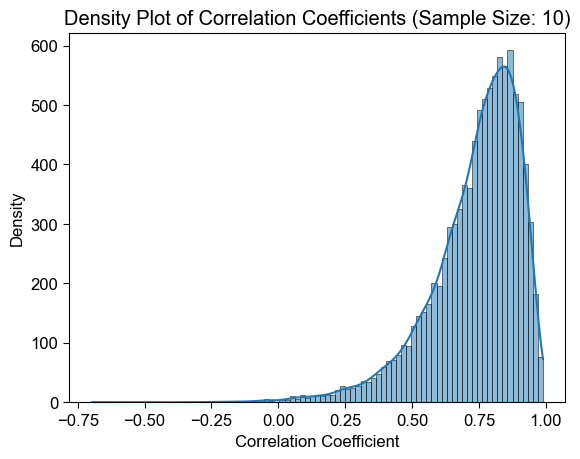

Average Correlation Estimate (Sample Size 20): 0.7497846679536702


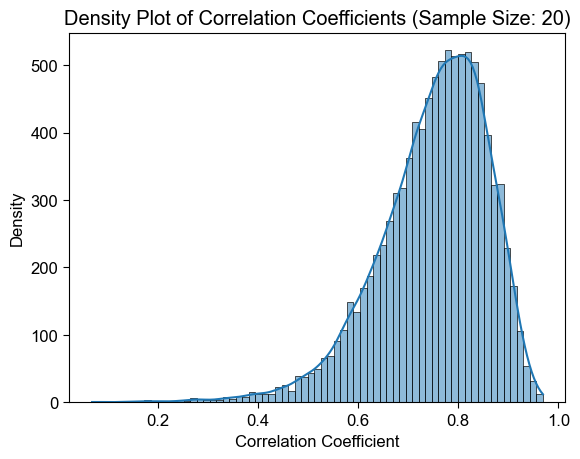

Average Correlation Estimate (Sample Size 30): 0.7524944082390448


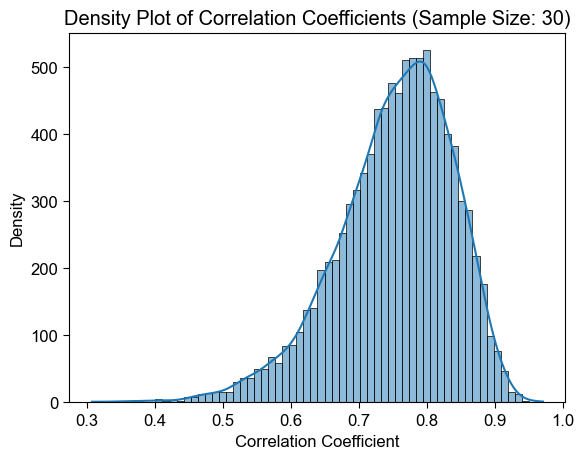

Average Correlation Estimate (Sample Size 40): 0.752939161807576


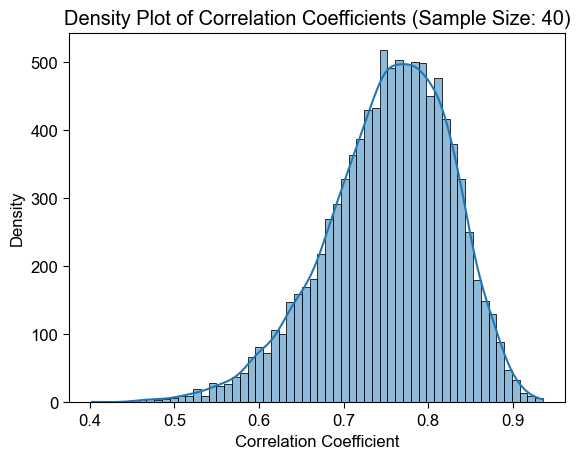

Average Correlation Estimate (Population): 0.7557051133044984


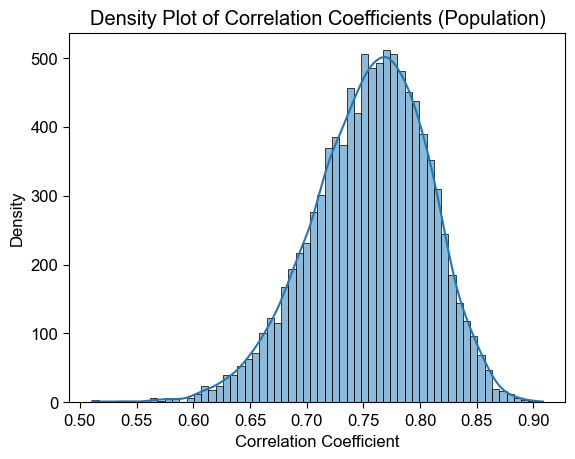

In [73]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have a pandas DataFrame named 'data' containing GPA and SAT scores

# Number of bootstrap samples
B = 10000
corr_real = data['GPA'].corr(data['SAT'])
# Different sample sizes to iterate through
sample_sizes = [5, 10, 20, 30, 40]
data = pd.read_csv('correl_pop.csv')
# Plotting for different sample sizes
for sample_size in sample_sizes:
    # Empty array to store correlation coefficients
    corr_coefs = np.zeros(B)

    # Perform bootstrap resampling
    for i in range(B):
        # Draw a bootstrap sample with replacement
        bootstrap_sample = data.sample(n=sample_size, replace=True)

        # Calculate correlation coefficient
        corr = bootstrap_sample['GPA'].corr(bootstrap_sample['SAT'])

        # Store correlation coefficient
        corr_coefs[i] = corr

    # Calculate average correlation estimate
    avg_corr_estimate = np.mean(corr_coefs)
    print(f"Average Correlation Estimate (Sample Size {sample_size}): {avg_corr_estimate}")

    # Plot the density plot for each sample size
    sns.histplot(corr_coefs, kde=True)
    plt.title(f'Density Plot of Correlation Coefficients (Sample Size: {sample_size})')
    plt.xlabel('Correlation Coefficient')
    plt.ylabel('Density')
    plt.show()

# Plotting for population

# Empty array to store correlation coefficients
corr_coefs_pop = np.zeros(B)

# Perform bootstrap resampling
for i in range(B):
    # Draw a bootstrap sample with replacement
    bootstrap_sample = data.sample(n=len(data), replace=True)

    # Calculate correlation coefficient
    corr = bootstrap_sample['GPA'].corr(bootstrap_sample['SAT'])

    # Store correlation coefficient
    corr_coefs_pop[i] = corr

# Calculate average correlation estimate
avg_corr_estimate = np.mean(corr_coefs_pop)
print(f"Average Correlation Estimate (Population): {avg_corr_estimate}")

# Plot the density plot for each sample size
sns.histplot(corr_coefs_pop, kde=True)
plt.title(f'Density Plot of Correlation Coefficients (Population)')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Density')
plt.show()

As we increase the sample size, the density plot and average correlation estimates converge directly to the population plot and correlation.

The Density Graph converges to the density graph of the population as the sample size increases. 

If I were to do boostrapping, I would choose sample_size as maximum as possible.

In [75]:
# Calculate 99%, 95%, 90%, 10%, 5%, 1% quantiles of the correlation coefficient for the population
quantiles = np.quantile(corr_coefs_pop, [0.01, 0.05, 0.1, 0.9, 0.95, 0.99])
print(f"99% Quantile: {quantiles[5]}")
print(f"95% Quantile: {quantiles[4]}")
print(f"90% Quantile: {quantiles[3]}")
print(f"10% Quantile: {quantiles[2]}")
print(f"5% Quantile: {quantiles[1]}")
print(f"1% Quantile: {quantiles[0]}")

99% Quantile: 0.8585794550099397
95% Quantile: 0.8329469340935952
90% Quantile: 0.8178449778466768
10% Quantile: 0.6881718872375565
5% Quantile: 0.6657229577774912
1% Quantile: 0.6223284561893925


In [76]:
# Calculate 99%, 95%, 90%, 10%, 5%, 1% quantiles of the correlation coefficient for the sample size = [40,30,20,10,5]
quantiles = []
for sample_size in sample_sizes:
    corr_coefs = np.zeros(B)
    for i in range(B):
        bootstrap_sample = data.sample(n=sample_size, replace=True)
        corr = bootstrap_sample['GPA'].corr(bootstrap_sample['SAT'])
        corr_coefs[i] = corr
    quantiles.append(np.quantile(corr_coefs, [0.01, 0.05, 0.1, 0.9, 0.95, 0.99]))
quantiles_df = pd.DataFrame(quantiles, columns=['1%', '5%', '10%', '90%', '95%', '99%'])
quantiles_df.index = sample_sizes
display(quantiles_df)

,1%,5%,10%,90%,95%,99%
5,-0.477458,0.045763,0.300985,0.965569,0.980893,0.995230
10,0.177159,0.408945,0.511636,0.915888,0.937913,0.965490
20,0.415800,0.546182,0.602539,0.874199,0.895765,0.928694
30,0.498229,0.592473,0.634638,0.854834,0.874787,0.906452
40,0.548395,0.620457,0.655216,0.841255,0.860884,0.891821


## Findings on Correlation Coefficient Quantiles

### Population Quantiles:
- The correlation coefficient quantiles for the population indicate the range of correlation values that encompass different percentages of the population.
- For instance, the 99% quantile indicates that 99% of the population correlation coefficients fall below that value, and similarly for other quantiles.
- The population 1% quantile is lower than the other quantiles, indicating that only 1% of the population has correlation coefficients lower than that value.

### Sample Size Effect:
- As the sample size increases, the range of quantiles narrows down, indicating a more precise estimation of the population correlation coefficient.
- With a larger sample size, the quantiles for each percentage (1%, 5%, 10%, 90%, 95%, 99%) tend to converge towards the population quantiles.
- For smaller sample sizes, there's more variability in the estimated correlation coefficients, leading to wider ranges of quantiles.

### Direction of Correlation:
- Across all sample sizes, the quantiles consistently indicate a positive correlation between GPA and SAT scores. This is evident from the fact that the lower quantiles are all positive values, and they increase as the sample size increases.

### Stability of Estimates:
- With increasing sample size, the estimates become more stable and reliable, as seen from the convergence of quantiles towards the population values.
- The 99% quantile tends to have the largest spread, reflecting the extreme values in the dataset, but this spread decreases with larger sample sizes.

In summary, these findings suggest that as the sample size increases, the estimates of correlation coefficients become more accurate and stable, converging towards the true population values. However, even with smaller sample sizes, the direction of correlation remains consistent, albeit with more variability in the estimates.


Average Correlation Estimate (Sample Size 18): 0.7474262490671149


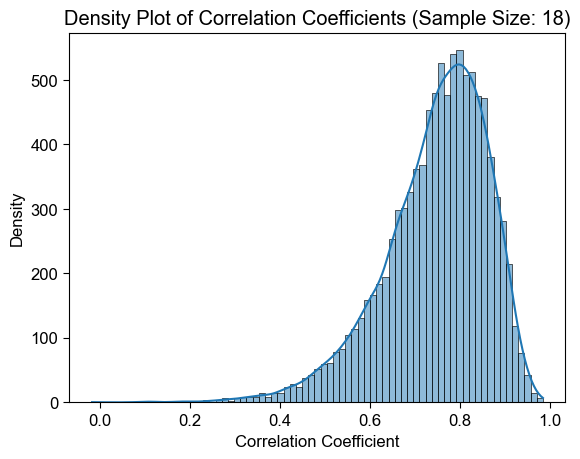

P-value: 0.5479


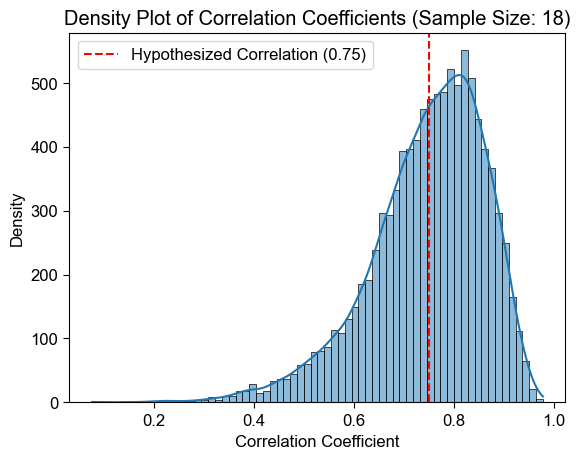

In [80]:
data = pd.read_csv('correl_pop.csv')

for i in range(B):
    # Draw a bootstrap sample with replacement
    bootstrap_sample = data.sample(n=18, replace=True)

    # Calculate correlation coefficient
    corr = bootstrap_sample['GPA'].corr(bootstrap_sample['SAT'])

    # Store correlation coefficient
    corr_coefs[i] = corr

# Calculate average correlation estimate
avg_corr_estimate = np.mean(corr_coefs)
print(f"Average Correlation Estimate (Sample Size {18}): {avg_corr_estimate}")

# Plot the density plot for each sample size
sns.histplot(corr_coefs, kde=True)
plt.title(f'Density Plot of Correlation Coefficients (Sample Size: {18})')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Density')
plt.show()

# Read the data
data = pd.read_csv('correl_pop.csv')

# Initialize array to store correlation coefficients
corr_coefs = np.zeros(B)

# Bootstrap procedure
for i in range(B):
    # Draw a bootstrap sample with replacement
    bootstrap_sample = data.sample(n=18, replace=True)

    # Calculate correlation coefficient
    corr = bootstrap_sample['GPA'].corr(bootstrap_sample['SAT'])

    # Store correlation coefficient
    corr_coefs[i] = corr

# Calculate proportion of correlation coefficients >= 0.75
p_value = np.mean(corr_coefs >= 0.75)

print(f"P-value: {p_value}")

# Plot the density plot for each sample size
sns.histplot(corr_coefs, kde=True)
plt.axvline(x=0.75, color='r', linestyle='--', label='Hypothesized Correlation (0.75)')
plt.title(f'Density Plot of Correlation Coefficients (Sample Size: {18})')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Density')
plt.legend()
plt.show()

95% Confidence Interval for Correlation Coefficient: [0.46830252 0.91358362]


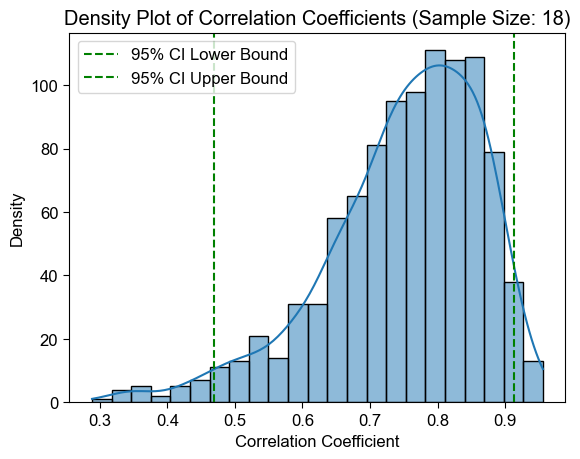

In [82]:
# Read the data
data = pd.read_csv('correl_pop.csv')

# Set the number of bootstrap samples
B = 1000  # Choose an appropriate number of bootstrap samples

# Initialize array to store correlation coefficients
corr_coefs = np.zeros(B)

# Bootstrap procedure
for i in range(B):
    # Draw a bootstrap sample with replacement
    bootstrap_sample = data.sample(n=18, replace=True)

    # Calculate correlation coefficient
    corr = bootstrap_sample['GPA'].corr(bootstrap_sample['SAT'])

    # Store correlation coefficient
    corr_coefs[i] = corr

# Calculate 95% confidence interval
confidence_interval = np.percentile(corr_coefs, [2.5, 97.5])

print(f"95% Confidence Interval for Correlation Coefficient: {confidence_interval}")

# Plot the density plot for each sample size
sns.histplot(corr_coefs, kde=True)
plt.axvline(x=confidence_interval[0], color='g', linestyle='--', label='95% CI Lower Bound')
plt.axvline(x=confidence_interval[1], color='g', linestyle='--', label='95% CI Upper Bound')
plt.title(f'Density Plot of Correlation Coefficients (Sample Size: {18})')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Density')
plt.legend()
plt.show()


# Question 7

In [90]:
df = 3  # degrees of freedom for t-distribution
mu = 0  # mean of the t-distribution
sample_sizes = [5, 10, 100, 500, 1000, 10000]  # different sample sizes to test
num_samples = 10000  # number of samples to draw for each sample size

def t_distribution(n):
    return np.random.standard_t(df, n)

In [91]:
sample_means = {}
sample_variances = {}
for n in sample_sizes:
    means = []
    variances = []
    for _ in range(num_samples):
        sample = t_distribution(n)
        means.append(np.mean(sample))
        variances.append(np.var(sample, ddof=1))  # Use ddof=1 for unbiased estimate
    sample_means[n] = means
    # Correct variance calculation: Variance of the means, not means of variances
    sample_variances[n] = np.var(means, ddof=1)

print("Sample Means:")
for n, means in sample_means.items():
    print(f"Sample Size: {n}, Mean: {np.mean(means)}")

print("\nSample Variances:")
for n, variances in sample_variances.items():
    print(f"Sample Size: {n}, Variance: {variances}")  

Sample Means:
Sample Size: 5, Mean: 0.0003749531649706375
Sample Size: 10, Mean: 0.005262530492810678
Sample Size: 100, Mean: 0.00038404048187167265
Sample Size: 500, Mean: 0.0008253622506321387
Sample Size: 1000, Mean: 4.281824541468793e-05
Sample Size: 10000, Mean: 0.00015504984035209676

Sample Variances:
Sample Size: 5, Variance: 0.5519666376084353
Sample Size: 10, Variance: 0.2937220233249303
Sample Size: 100, Variance: 0.0296699712707677
Sample Size: 500, Variance: 0.005856015533098508
Sample Size: 1000, Variance: 0.0029463628844029377
Sample Size: 10000, Variance: 0.00030298995895591515


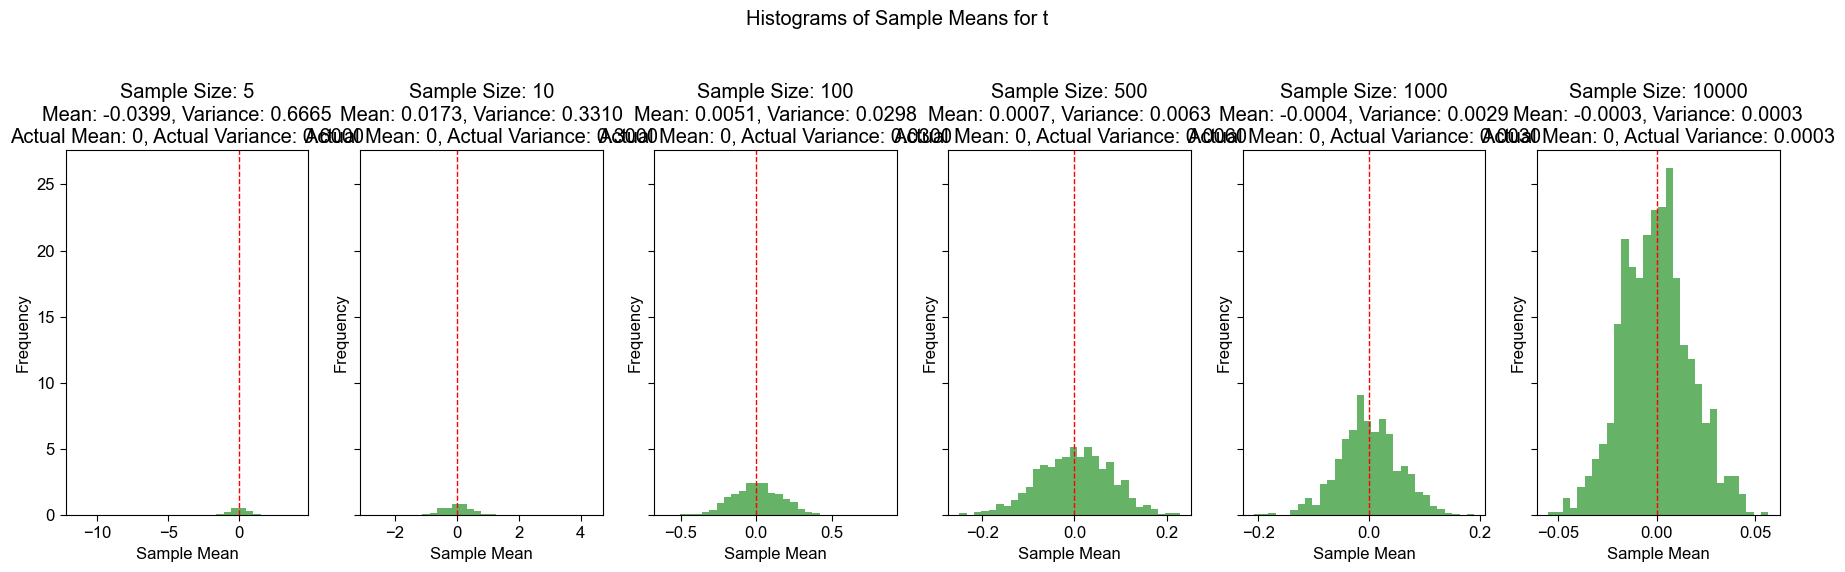

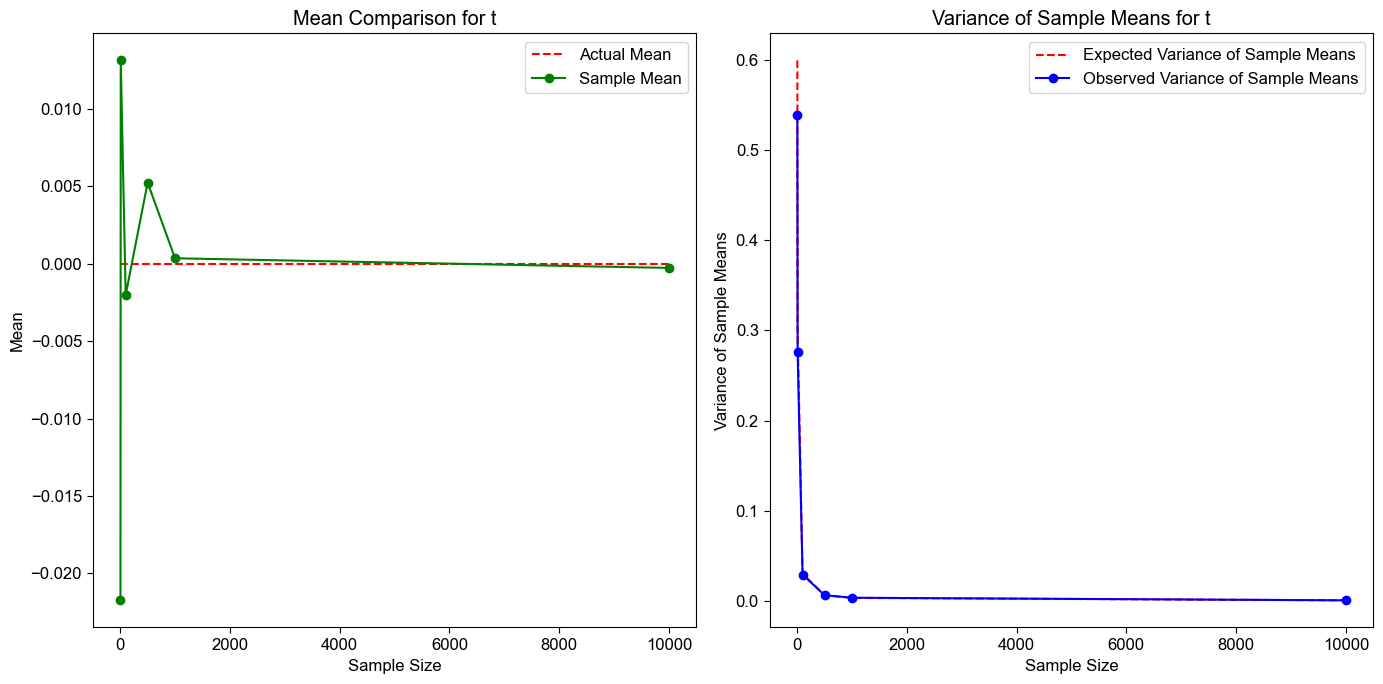

In [97]:
def t_distribution(n):
    return np.random.standard_t(3, n)


# Function to generate sample stats
def generate_sample_stats(distribution_func, sample_sizes, num_samples):
    sample_means = {}
    sample_variances = {}
    for n in sample_sizes:
        means = []
        variances = []
        for _ in range(num_samples):
            sample = distribution_func(n)
            means.append(np.mean(sample))
            variances.append(np.var(sample, ddof=1))  # Use ddof=1 for unbiased estimate
        sample_means[n] = means
        # Correct variance calculation: Variance of the means, not means of variances
        sample_variances[n] = np.var(means, ddof=1)
    return sample_means, sample_variances

# Main distribution parameters
main_distribution = {
    "t": {"mean": 0, "variance": 3}
}

# Sample sizes and number of samples
sample_sizes = [5,10,100,500,1000,10000]
num_samples = 1000

# Generate sample means and variances for each distribution
for distribution_name, params in main_distribution.items():
    distribution_func = globals()[f"{distribution_name.lower()}_distribution"]
    actual_mean = params["mean"]
    actual_variance = params["variance"]

    sample_means, sample_variances = generate_sample_stats(distribution_func, sample_sizes, num_samples)

    # Plotting histograms for the means of sample sizes 10, 100, 1000
    fig, axs = plt.subplots(1, 6, figsize=(18, 6), sharey=True)
    fig.suptitle(f'Histograms of Sample Means for {distribution_name}')

    for ax, (n, means) in zip(axs, sample_means.items()):
        ax.hist(means, bins=30, density=True, alpha=0.6, color='g')
        ax.axvline(actual_mean, color='r', linestyle='dashed', linewidth=1)
        ax.set_title(f'Sample Size: {n}\nMean: {np.mean(means):.4f}, Variance: {np.var(means, ddof=1):.4f}\nActual Mean: {actual_mean}, Actual Variance: {actual_variance / n:.4f}')
        ax.set_xlabel('Sample Mean')
        ax.set_ylabel('Frequency')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


# Step 2: Define a function to generate sample means and variances
def generate_sample_stats(distribution_func, sample_sizes, num_samples):
    sample_means = []
    sample_variances = []
    for n in sample_sizes:
        means = []
        variances = []
        for _ in range(num_samples):
            sample = distribution_func(n)
            means.append(np.mean(sample))
            variances.append(np.var(sample, ddof=1))  # Use ddof=1 for unbiased estimate
        sample_means.append(np.mean(means))
        # Correct variance calculation: Variance of the means, not means of variances
        sample_variances.append(np.var(means, ddof=1))
    return sample_means, sample_variances


# Define main distribution parameters
main_distribution = {
    "t": {"mean": 0, "variance": 3}
}

# Define sample sizes and number of samples
sample_sizes = [5,10,100,500,1000,10000]
num_samples = 1000

# Generate sample means and variances for each distribution, and plot the results
for distribution_name, params in main_distribution.items():
    distribution_func = globals()[f"{distribution_name.lower()}_distribution"]
    actual_mean = params["mean"]
    actual_variance = params["variance"]

    sample_means, sample_variances = generate_sample_stats(distribution_func, sample_sizes, num_samples)

    # Plotting Mean and Variance changes
    plt.figure(figsize=(14, 7))

    # Plot for Means
    plt.subplot(1, 2, 1)
    plt.plot(sample_sizes, [actual_mean] * len(sample_sizes), 'r--', label='Actual Mean')
    plt.plot(sample_sizes, sample_means, 'g-o', label='Sample Mean')
    plt.xlabel('Sample Size')
    plt.ylabel('Mean')
    plt.title(f'Mean Comparison for {distribution_name}')
    plt.legend()

    # Plot for Variance of Sample Means
    plt.subplot(1, 2, 2)
    expected_variance = [actual_variance / n for n in sample_sizes]  # Expected decrease as per CLT
    plt.plot(sample_sizes, expected_variance, 'r--', label='Expected Variance of Sample Means')
    plt.plot(sample_sizes, sample_variances, 'b-o', label='Observed Variance of Sample Means')
    plt.xlabel('Sample Size')
    plt.ylabel('Variance of Sample Means')
    plt.title(f'Variance of Sample Means for {distribution_name}')
    plt.legend()

    plt.tight_layout()
    plt.show()
# Repeat the plotting process for other distributions as needed

As we can see, mean is going to 0 & variance is going to 0.

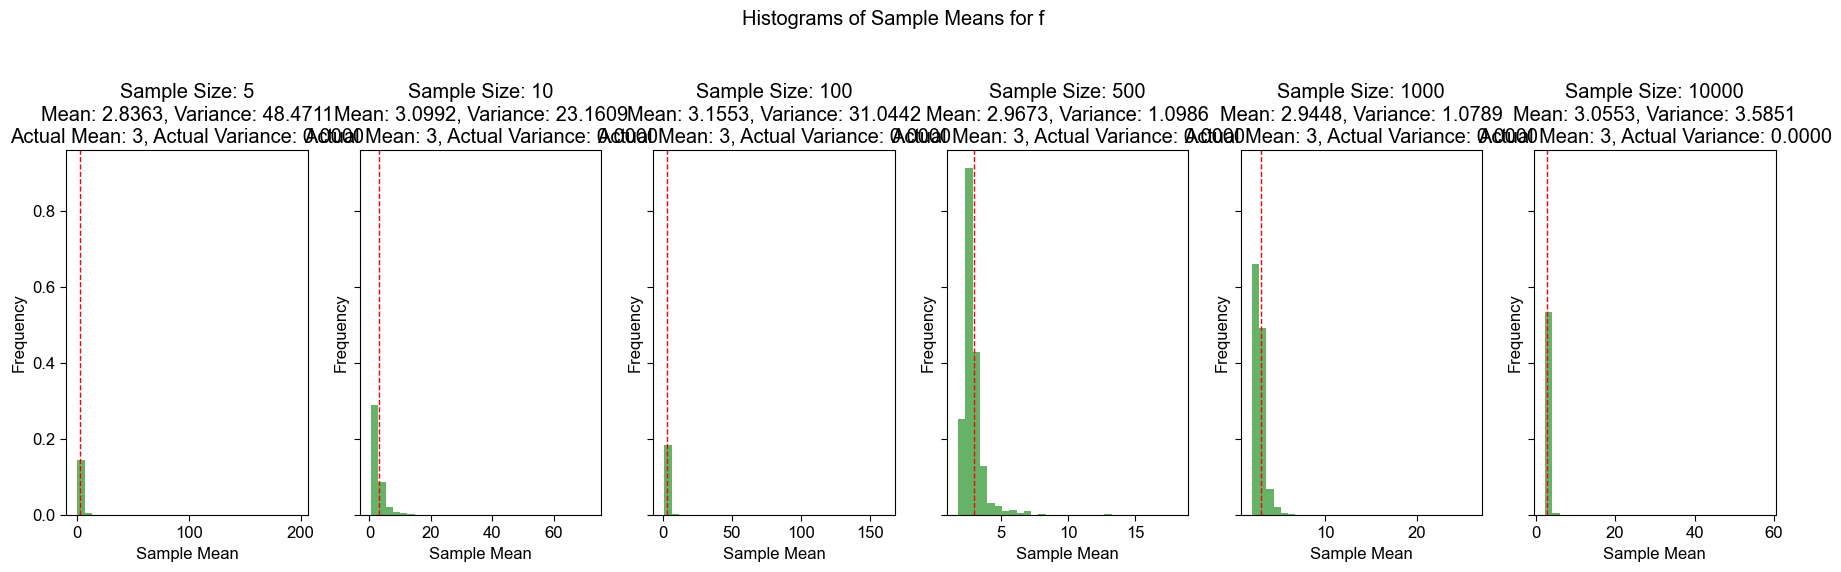

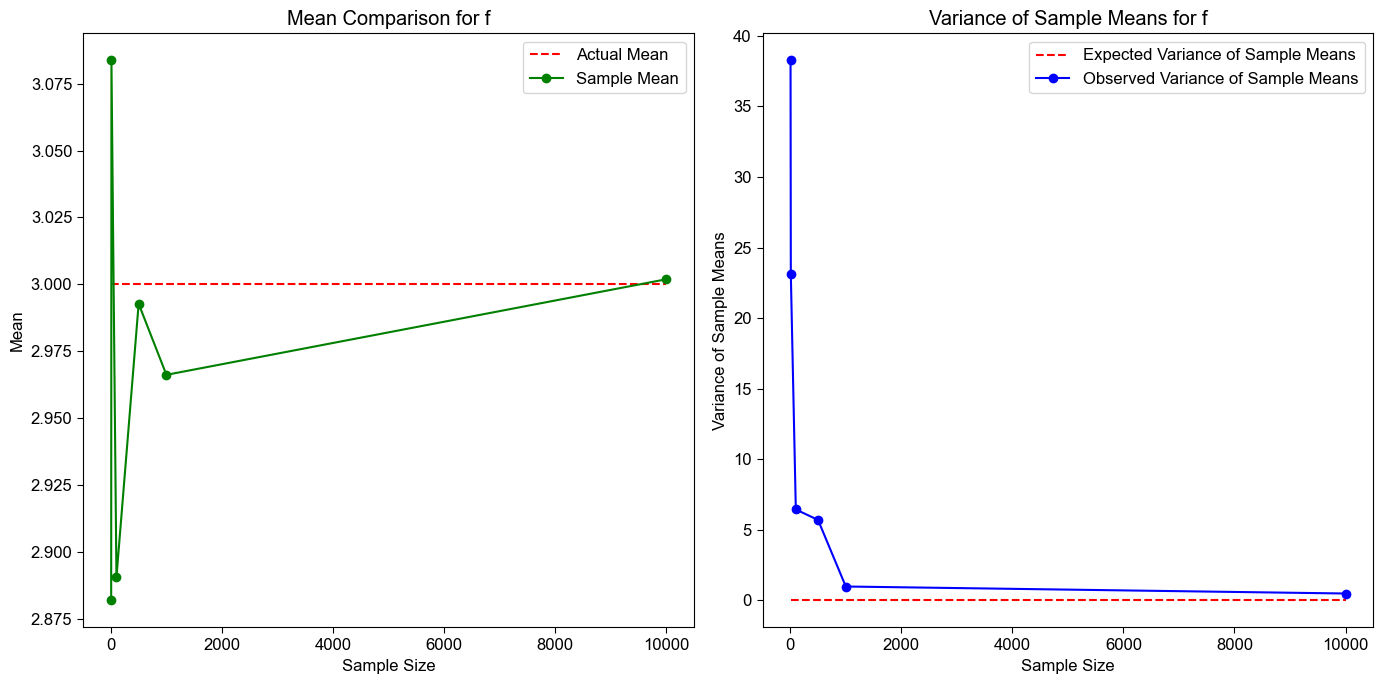

In [103]:
# Use f-distribution with df = 3
def f_distribution(n):
    return np.random.f(df, df, n)


def t_distribution(n):
    return np.random.standard_t(3, n)


# Function to generate sample stats
def generate_sample_stats(distribution_func, sample_sizes, num_samples):
    sample_means = {}
    sample_variances = {}
    for n in sample_sizes:
        means = []
        variances = []
        for _ in range(num_samples):
            sample = distribution_func(n)
            means.append(np.mean(sample))
            variances.append(np.var(sample, ddof=1))  # Use ddof=1 for unbiased estimate
        sample_means[n] = means
        # Correct variance calculation: Variance of the means, not means of variances
        sample_variances[n] = np.var(means, ddof=1)
    return sample_means, sample_variances

# Main distribution parameters
main_distribution = {
    "f": {"mean": 3, "variance": 0}
}

# Sample sizes and number of samples
sample_sizes = [5,10,100,500,1000,10000]
num_samples = 1000

# Generate sample means and variances for each distribution
for distribution_name, params in main_distribution.items():
    distribution_func = globals()[f"{distribution_name.lower()}_distribution"]
    actual_mean = params["mean"]
    actual_variance = params["variance"]

    sample_means, sample_variances = generate_sample_stats(distribution_func, sample_sizes, num_samples)

    # Plotting histograms for the means of sample sizes 10, 100, 1000
    fig, axs = plt.subplots(1, 6, figsize=(18, 6), sharey=True)
    fig.suptitle(f'Histograms of Sample Means for {distribution_name}')

    for ax, (n, means) in zip(axs, sample_means.items()):
        ax.hist(means, bins=30, density=True, alpha=0.6, color='g')
        ax.axvline(actual_mean, color='r', linestyle='dashed', linewidth=1)
        ax.set_title(f'Sample Size: {n}\nMean: {np.mean(means):.4f}, Variance: {np.var(means, ddof=1):.4f}\nActual Mean: {actual_mean}, Actual Variance: {actual_variance / n:.4f}')
        ax.set_xlabel('Sample Mean')
        ax.set_ylabel('Frequency')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


# Step 2: Define a function to generate sample means and variances
def generate_sample_stats(distribution_func, sample_sizes, num_samples):
    sample_means = []
    sample_variances = []
    for n in sample_sizes:
        means = []
        variances = []
        for _ in range(num_samples):
            sample = distribution_func(n)
            means.append(np.mean(sample))
            variances.append(np.var(sample, ddof=1))  # Use ddof=1 for unbiased estimate
        sample_means.append(np.mean(means))
        # Correct variance calculation: Variance of the means, not means of variances
        sample_variances.append(np.var(means, ddof=1))
    return sample_means, sample_variances


# Define main distribution parameters
main_distribution = {
    "f": {"mean": 3, "variance": 0}
}

# Define sample sizes and number of samples
sample_sizes = [5,10,100,500,1000,10000]
num_samples = 1000

# Generate sample means and variances for each distribution, and plot the results
for distribution_name, params in main_distribution.items():
    distribution_func = globals()[f"{distribution_name.lower()}_distribution"]
    actual_mean = params["mean"]
    actual_variance = params["variance"]

    sample_means, sample_variances = generate_sample_stats(distribution_func, sample_sizes, num_samples)

    # Plotting Mean and Variance changes
    plt.figure(figsize=(14, 7))

    # Plot for Means
    plt.subplot(1, 2, 1)
    plt.plot(sample_sizes, [actual_mean] * len(sample_sizes), 'r--', label='Actual Mean')
    plt.plot(sample_sizes, sample_means, 'g-o', label='Sample Mean')
    plt.xlabel('Sample Size')
    plt.ylabel('Mean')
    plt.title(f'Mean Comparison for {distribution_name}')
    plt.legend()

    # Plot for Variance of Sample Means
    plt.subplot(1, 2, 2)
    expected_variance = [actual_variance / n for n in sample_sizes]  # Expected decrease as per CLT
    plt.plot(sample_sizes, expected_variance, 'r--', label='Expected Variance of Sample Means')
    plt.plot(sample_sizes, sample_variances, 'b-o', label='Observed Variance of Sample Means')
    plt.xlabel('Sample Size')
    plt.ylabel('Variance of Sample Means')
    plt.title(f'Variance of Sample Means for {distribution_name}')
    plt.legend()

    plt.tight_layout()
    plt.show()
# Repeat the plotting process for other distributions as needed


Again, as in the t-distribution, in the f-distribution, as the sample size increased, the sample_mean converged to the true_mean and the variance went towards 0.